# Cadastro Unico: Exploratory analysis
## Introduction
In this notebook, we explore the Cadastro Unico dataset of 2018. The Cadastro Unico of the Federal Government's Social Programs provides information about low-income families, presenting detailed information regarding their income, homes, and other socioeconomic indicators. We consider the dataset of 2018, which consists of unidentified samples, i.e., the information provided in the dataset assures the security of personal information. The datasets are available at the Ministry of Citizenship webpage, with data from 2012 to 2018:
https://aplicacoes.mds.gov.br/sagi/portal/index.php?grupo=212. The Cadastro Unico datasets are available in the CSV format, with 30 variables related to families and 34 related to people.

**Scope and objective.** In this notebook, we analyze the data related to the families only (more than 4M entries), even though in a future moment we will analyze it together with the individuals dataset. The main goal of this notebook is to provide an overall view of the dataset, indicating the most prominent findings through data visualization and basic statistics. Therefore, this notebook is intended to be used as the first step of a more detailed data analysis.

## Imports and dataset load
First, we import some required packages, and load the dataset.

In [1]:
library(ggplot2)
library(psych)
library(repr)
library(gridExtra)
library(corrplot)
library(viridis)
library(mltools)
library(data.table)
library(caret)
library(Hmisc)


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


corrplot 0.84 loaded

Loading required package: viridisLite

Loading required package: lattice

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: Formula


Attaching package: ‘Hmisc’


The following object is masked from ‘package:psych’:

    describe


The following objects are masked from ‘package:base’:

    format.pval, units




In [2]:
# Load the dataset
df <- read.csv(file = 'data/base_familia_2018.csv', header = TRUE, sep = ';')

In [3]:
# Get an overview of the dataset, and print the number of rows and columns
head(df)
nrow(df)
ncol(df)

,cd_ibge,estrato,classf,id_familia,dat_cadastramento_fam,dat_alteracao_fam,vlr_renda_media_fam,dat_atualizacao_familia,cod_local_domic_fam,cod_especie_domic_fam,⋯,cod_familia_indigena_fam,ind_familia_quilombola_fam,nom_estab_assist_saude_fam,cod_eas_fam,nom_centro_assist_fam,cod_centro_assist_fam,ind_parc_mds_fam,marc_pbf,qtde_pessoas,peso.fam
,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<int>,<int>,⋯,<int>,<int>,<fct>,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>
1,3205002,2,2,1,2018-06-28,2018-10-02,244,2018-06-28,1,1,⋯,2,2,,NA,CRAS DE SERRA SEDE,32050034575,0,0,5,5.502565e+14
2,3205101,2,2,3,2018-08-27,2018-11-29,60,2018-11-29,1,1,⋯,2,2,,NA,CRAS VIANA,32051030269,0,1,5,5.503557e+14
3,3201308,2,2,4,2018-02-23,2018-02-27,937,2018-02-23,1,1,⋯,2,2,,NA,CRAS IV ALTO MUCURI,32013002407,0,0,1,5.502597e+14
4,3201308,2,2,6,2013-12-27,2018-10-01,44,2017-06-22,1,1,⋯,2,2,US CAMPO VERDE,2652994,CRAS III CAMPO VERDE,32013002406,0,1,2,5.502597e+14
5,3205002,2,2,7,2018-03-26,2018-03-28,0,2018-03-26,1,1,⋯,2,2,UNIDADE REGIONAL DE SAUDE SERRA,2465795,,NA,0,1,2,5.502565e+14
6,3205002,2,2,8,2016-10-27,2018-10-01,176,2016-10-27,1,1,⋯,2,2,UNIDADE BASICA DE SAUDE VILA NOVA DE COLARES,2522845,CRAS DE VILA NOVA DE COLARES,32050002912,0,1,5,5.502565e+14


[1] 4807996

[1] 31

## Pre-processing and data cleaning
We first get an overview of missing data, by displaying the number of NA entries in each column. In the sub-sequent cells, we rename some categorical variables, remove some columns and merge some categories.

In [4]:
# Get the number of NAs in each column
data.frame(colSums(is.na(df)))

,colSums.is.na.df..
,<dbl>
cd_ibge,0
estrato,0
classf,0
id_familia,0
dat_cadastramento_fam,0
dat_alteracao_fam,0
vlr_renda_media_fam,138
dat_atualizacao_familia,0
cod_local_domic_fam,20727


In [5]:
# Treat the 'cod_escoa_sanitario_domic_fam' column
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 1] <- 'Rede coletora'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 2] <- 'Fossa septica'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 3] <- 'Fossa rudimentar'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 4] <- 'Vala a ceu aberto'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 5] <- 'Rio, lago ou mar'

# Convert 'Outro' and 'NA' to 'others'
df$cod_escoa_sanitario_domic_fam[is.na(df$cod_escoa_sanitario_domic_fam)] <- 'Outro'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 6] <- 'Outro'

# Display 'cod_escoa_sanitario_domic_fam'
data.frame(table(df$cod_escoa_sanitario_domic_fam))

Var1,Freq
<fct>,<int>
Fossa rudimentar,1244054
Fossa septica,648989
Outro,526214
Rede coletora,2257758
"Rio, lago ou mar",42899
Vala a ceu aberto,88082


In [6]:
# The 'ind_familia_quilombola_fam' column presents 'NA' for samples classified as indigena.
# As very few samples are marked as quilombola, we join it with indigena, creating the column 'indigena_quilombola'
df$ind_familia_quilombola_fam[is.na(df$ind_familia_quilombola_fam)] <- 1
names(df)[names(df) == 'ind_familia_quilombola_fam'] <- 'indigena_quilombola'

In [7]:
# Code convention: convert values with 2 (meaning no presence) to 0
df$cod_local_domic_fam[df$cod_local_domic_fam == 2] <- 0
df$cod_familia_indigena_fam[df$cod_familia_indigena_fam == 2] <- 0
df$cod_banheiro_domic_fam[df$cod_banheiro_domic_fam == 2] <- 0
df$cod_agua_canalizada_fam[df$cod_agua_canalizada_fam == 2] <- 0
df$indigena_quilombola[df$indigena_quilombola == 2] <- 0

# Code convention: convert estrato values -- (0) Rural, (1) Urban
df$estrato[df$estrato == 1] <- 0
df$estrato[df$estrato == 2] <- 1

# Code convention: convert classf values -- (0) Other, (1) RM ou RIDE
df$classf[df$classf == 3] <- 0
df$classf[df$classf == 2] <- 1

In [8]:
# Get uninformative columns or columns with many NA entries
drop <- c(
    'cd_ibge',
    'dat_cadastramento_fam',
    'dat_alteracao_fam',
    'dat_atualizacao_familia',
    'nom_estab_assist_saude_fam',
    'cod_eas_fam',
    'nom_centro_assist_fam',
    'cod_centro_assist_fam',
    'ind_parc_mds_fam',
    'peso.fam',
    'cod_familia_indigena_fam',
    'ind_familia_quilombola_fam',
    'id_familia'
)

# Remove columns
df <- df[, !(names(df) %in% drop)]

# We have some samples with NA entries. As for these samples the NAs occur in most columns and
# the number os samples with NA are not significant, we remove these rows
df <- na.omit(df)

In [9]:
# Treating 'cod_material_piso_fam'
df$cod_material_piso_fam[df$cod_material_piso_fam == 2] <- 'Cimento'
df$cod_material_piso_fam[df$cod_material_piso_fam == 5] <- 'Ceramica, lajota ou pedra'

# As the 'Madeira' class has few samples, we join 'Madeira aproveitada' and 'Madeira aparelhada'
df$cod_material_piso_fam[df$cod_material_piso_fam == 3] <- 'Madeira'
df$cod_material_piso_fam[df$cod_material_piso_fam == 4] <- 'Madeira'

# As 'Terra', 'Carpete', and 'Outro' has few samples, we agreggate them in 'Others'
df$cod_material_piso_fam[df$cod_material_piso_fam == 1] <- 'Outro'
df$cod_material_piso_fam[df$cod_material_piso_fam == 6] <- 'Outro'
df$cod_material_piso_fam[df$cod_material_piso_fam == 7] <- 'Outro'

# Display 'cod_material_piso_fam'
data.frame(table(df$cod_material_piso_fam))

Var1,Freq
<fct>,<int>
"Ceramica, lajota ou pedra",2301605
Cimento,1828693
Madeira,237413
Outro,215666


In [10]:
# Treating 'cod_material_domic_fam'
df$cod_material_domic_fam[df$cod_material_domic_fam == 1] <- 'Alvenaria (com revestimento)'
df$cod_material_domic_fam[df$cod_material_domic_fam == 2] <- 'Alvenaria (sem revestimento)'

# Joining 'Madeira aproveitada' and 'Madeira aparelhada'
df$cod_material_domic_fam[df$cod_material_domic_fam == 3] <- 'Madeira'
df$cod_material_domic_fam[df$cod_material_domic_fam == 6] <- 'Madeira'

# Joining 'Taipa revestida' and 'Taipa nao revestida'
df$cod_material_domic_fam[df$cod_material_domic_fam == 4] <- 'Taipa'
df$cod_material_domic_fam[df$cod_material_domic_fam == 5] <- 'Taipa'

# Joining 'Palha', and 'Outro'
df$cod_material_domic_fam[df$cod_material_domic_fam == 7] <- 'Outro'
df$cod_material_domic_fam[df$cod_material_domic_fam == 8] <- 'Outro'

# Display 'cod_material_domic_fam'
data.frame(table(df$cod_material_domic_fam))

Var1,Freq
<fct>,<int>
Alvenaria (com revestimento),3363935
Alvenaria (sem revestimento),690153
Madeira,350934
Outro,65730
Taipa,112625


In [11]:
# Treating 'cod_abaste_agua_domic_fam'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 1] <- 'Rede de distribuicao'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 2] <- 'Poco ou nascente'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 3] <- 'Cisterna'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 4] <- 'Outro'

# Display 'cod_abaste_agua_domic_fam'
data.frame(table(df$cod_abaste_agua_domic_fam))

Var1,Freq
<fct>,<int>
Cisterna,143198
Outro,210949
Poco ou nascente,692979
Rede de distribuicao,3536251


In [12]:
# Display 'cod_especie_domic_fam'
data.frame(table(df$cod_especie_domic_fam))

# After removing the NA entries, the cod_especie_domic_fam column has only one value, so we remove it
df <- df[, !(names(df) %in% c('cod_especie_domic_fam'))]

Var1,Freq
<fct>,<int>
1,4583377


In [13]:
# Treating 'cod_destino_lixo_domic_fam'
df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 1] <- 'Coletado'
df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 2] <- 'Coletado'

df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 3] <- 'Queimado ou enterrado'

df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 4] <- 'Descartado na natureza'
df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 5] <- 'Descartado na natureza'

df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 6] <- 'Outro'

# Display 'cod_destino_lixo_domic_fam'
data.frame(table(df$cod_destino_lixo_domic_fam))

Var1,Freq
<fct>,<int>
Coletado,3836692
Descartado na natureza,63763
Outro,18025
Queimado ou enterrado,664897


In [14]:
# Treating 'cod_iluminacao_domic_fam'

# We join 'Eletrica com medidor proprio', 'Eletrica com medidor comunitario', and 'Eletrica sem medidor' in one class
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 1] <- 1
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 2] <- 1
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 3] <- 1

# We join 'Oleo/Querosene/Gas', 'Vela', and 'Outro' in one class
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 4] <- 0
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 5] <- 0
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 6] <- 0

# Display 'cod_iluminacao_domic_fam', which is now a binary variable -- (0) no eletricity, (1) has eletricity
data.frame(table(df$cod_iluminacao_domic_fam))

Var1,Freq
<fct>,<int>
0,146798
1,4436579


In [15]:
# Treating 'cod_calcamento_domic_fam'

# We join 'Parcial' and 'Total'
df$cod_calcamento_domic_fam[df$cod_calcamento_domic_fam == 2] <- 1

# And mark 'Nao existe' as 0
df$cod_calcamento_domic_fam[df$cod_calcamento_domic_fam == 3] <- 0

# Display 'cod_calcamento_domic_fam', which is now a binary variable -- (0) no calcamento, (1) has calcamento
data.frame(table(df$cod_calcamento_domic_fam))

Var1,Freq
<fct>,<int>
0,1579128
1,3004249


In [16]:
# Define a customized theme to be shared by our plots
mytheme <- theme(text = element_text(size = 20))

## Average income
In this section, we present some preliminary analysis regarding the families income. In a first moment, we devide the income into intervals, and present the average income (per capita) distribution of three groups: overall population, families not registered in the BF program, and families registered in the BF program. Next, we present the average income by social groups.

**Summary:**

* The average income of indigenous or quilombola families is less than the average income of other families;

* The average income of families registered in the BF program is lower than the average income of other families (as expected, due to the program's conception). Approximatly 80% of families registered in the BF program has an average per capita income smaller than 100 reais. This income range occurs in around 10% of non BF families;

* The average income of families living in urban areas is higher than the average income of families living in rural areas;

* There is no significant difference in the income of families living in the GM1 (cities between 100 and 5k families) and GM2 strata (cities with more than 5k families).

In [17]:
# Define the income intervals. We consider intervals from 0 to 1000 (stepping by 100), and a last interval >= 1000
inter <- seq(0, 1000, by = 100)

# Arrays storing the number of families in each income segment, for each category (all, non BF, BF)
freq_renda_all <- rep(0, length(inter))
freq_renda_bf0 <- rep(0, length(inter))
freq_renda_bf1 <- rep(0, length(inter))

# Count the number of families in each income segment
for(i in seq(1, length(inter) - 1)) {
    str <- inter[i]
    end <- inter[i+1]
    freq_renda_all[i] <- nrow(df[df$vlr_renda_media_fam >= str & df$vlr_renda_media_fam < end,])
    freq_renda_bf0[i] <- nrow(df[df$marc_pbf == 0 & df$vlr_renda_media_fam >= str & df$vlr_renda_media_fam < end,])
    freq_renda_bf1[i] <- nrow(df[df$marc_pbf == 1 & df$vlr_renda_media_fam >= str & df$vlr_renda_media_fam < end,])
}

# Add the last income segment (>= 1000) and counts the number of families
freq_renda_all[length(inter)] <- nrow(df[df$vlr_renda_media_fam >= end,])
freq_renda_bf0[length(inter)] <- nrow(df[df$marc_pbf == 0 & df$vlr_renda_media_fam >= end,])
freq_renda_bf1[length(inter)] <- nrow(df[df$marc_pbf == 1 & df$vlr_renda_media_fam >= end,])

# Calculate the frequencies in terms of percentage
perc_renda_all <- 100*round(freq_renda_all/sum(freq_renda_all), 3)
perc_renda_all <- paste(perc_renda_all, '%', sep = '')

perc_renda_bf0 <- 100*round(freq_renda_bf0/sum(freq_renda_bf0), 3)
perc_renda_bf0 <- paste(perc_renda_bf0, '%', sep = '')

perc_renda_bf1 <- 100*round(freq_renda_bf1/sum(freq_renda_bf1), 3)
perc_renda_bf1 <- paste(perc_renda_bf1, '%', sep = '')

# Define the intervals as strings (to place in the x-axis of the plots)
intervals <- c('< 100', '100 a 200', '200 a 300', '300 a 400', '400 a 500',
               '500 a 600', '600 a 700', '700 a 800', '800 a 900', '900 a 1000', '>= 1000')
intervals <- factor(intervals, levels = intervals)

# Build the data frames for each category
data_histogram_all <- data.frame(salary_range = factor(intervals), freq = freq_renda_all, perc = perc_renda_all)
data_histogram_bf0 <- data.frame(salary_range = factor(intervals), freq = freq_renda_bf0, perc = perc_renda_bf0)
data_histogram_bf1 <- data.frame(salary_range = factor(intervals), freq = freq_renda_bf1, perc = perc_renda_bf1)

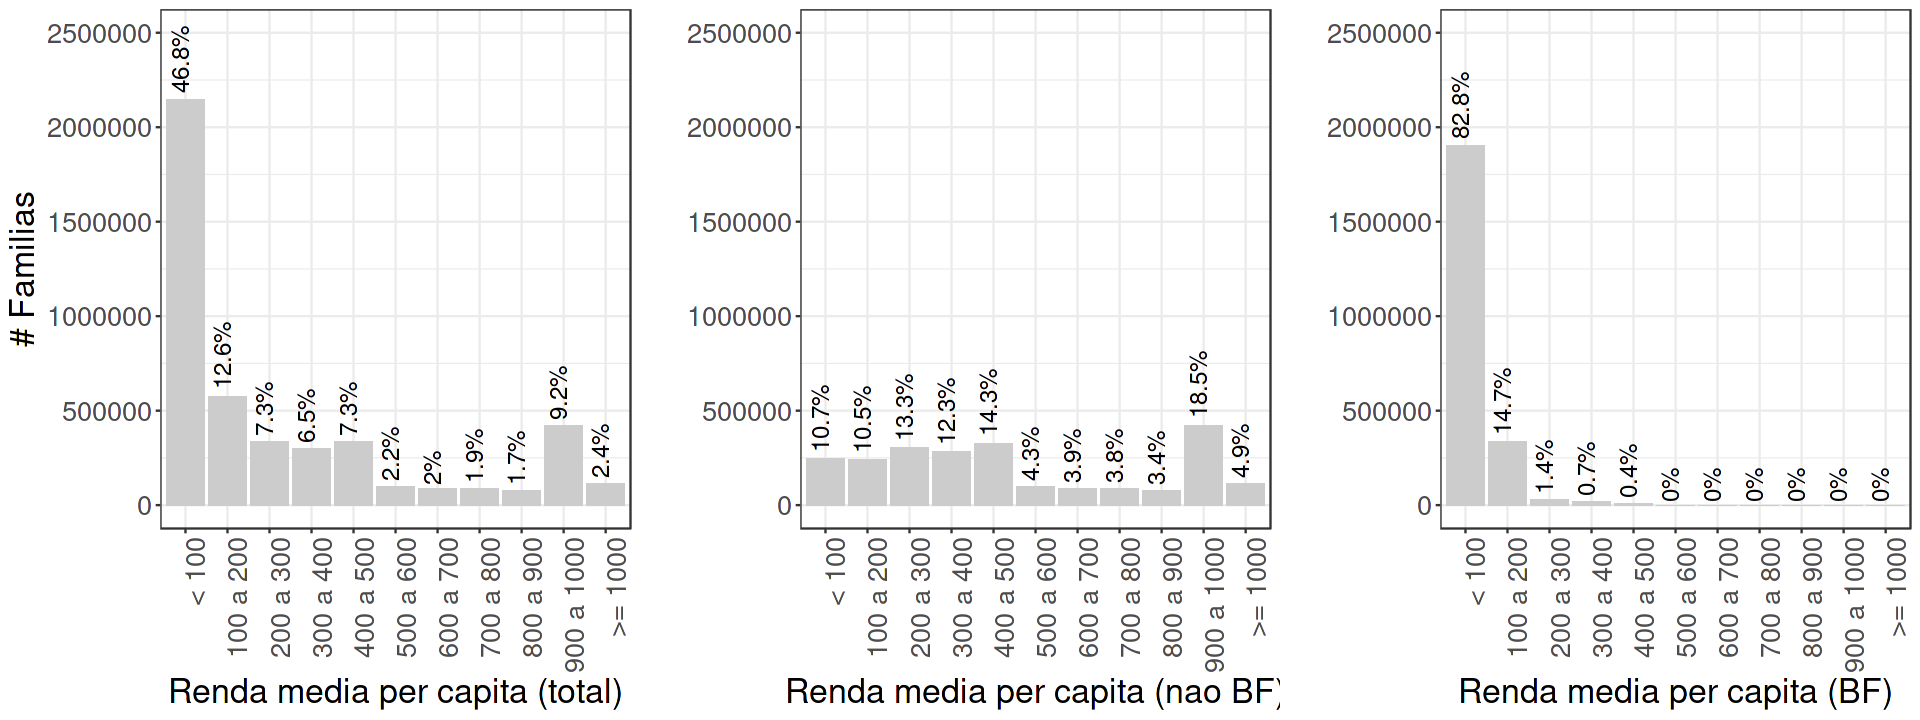

In [64]:
# Vertical bound of the plot
max_y <- 2500000
break_y <- 500000

# Plot of income distribution for the entire population
plt_renda_all <- ggplot(data_histogram_all, aes(salary_range, freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme + 
    ylab("# Familias") +
    xlab("Renda media per capita (total)") +
    geom_text(aes(label = perc_renda_all), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

# Plot of income distribution for non BF families
plt_renda_bf0 <- ggplot(data_histogram_bf0, aes(salary_range, freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme + 
    ylab("") +
    xlab("Renda media per capita (nao BF)") +
    geom_text(aes(label = perc_renda_bf0), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

# Plot of income distribution for BF families
plt_renda_bf1 <- ggplot(data_histogram_bf1, aes(salary_range, freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme + 
    ylab("") +
    xlab("Renda media per capita (BF)") +
    geom_text(aes(label = perc_renda_bf1), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

# Display plots side-by-side
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(plt_renda_all, plt_renda_bf0, plt_renda_bf1, ncol = 3)

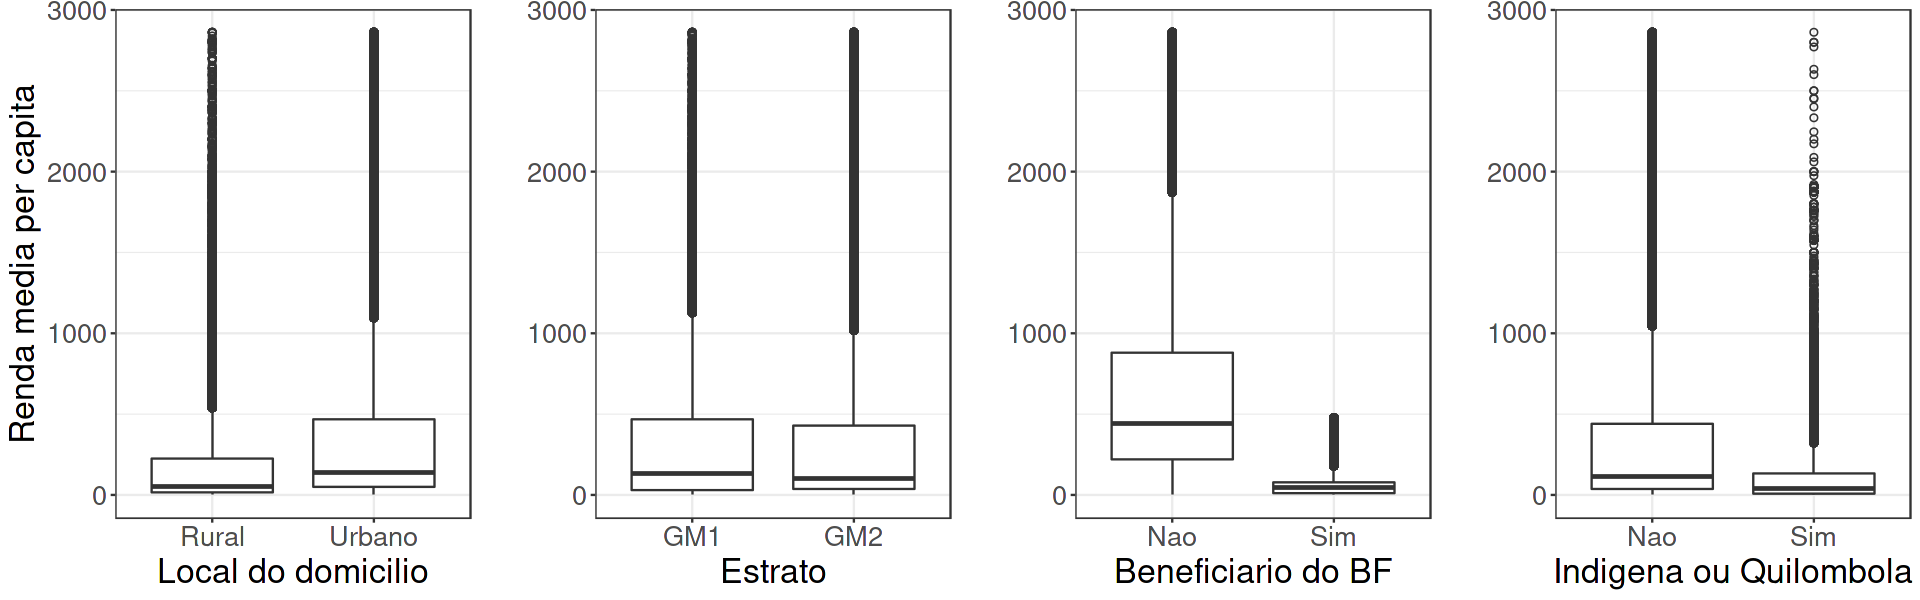

In [19]:
# Plot of income distribution according to Local do domicilio (Rural vs Urbano)
plt_local <- ggplot(df, aes(x = factor(cod_local_domic_fam, levels = 0:1, labels = c('Rural', 'Urbano')),
                            y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    mytheme +
    ylab("Renda media per capita") +
    xlab("Local do domicilio")

# Plot of income distribution according to Estrato (GM1 vs GM2)
# GM1 corresponds to municipios (counties) with 100 to 5k families, whereas GM2 has > 5k municipios
plt_estrato <- ggplot(df, aes(x = factor(estrato, levels = 0:1, labels = c('GM1', 'GM2')),
                              y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Estrato")

# Plot of income distribution according to the BF program (non BF families vs BF families)
plt_bf <- ggplot(df, aes(x = factor(marc_pbf, levels = 0:1, labels = c('Nao', 'Sim')),
                         y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiario do BF")

# Plot of income distribution among Indigena/Quilombola and non Indigena/Quilombola
plt_ind_qui <- ggplot(df, aes(x = factor(indigena_quilombola, levels = 0:1, labels = c('Nao', 'Sim')),
                         y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Indigena ou Quilombola")

# Display plots side-by-side
options(repr.plot.width = 16, repr.plot.height = 5)
grid.arrange(plt_local, plt_estrato, plt_bf, plt_ind_qui, ncol = 4)

## Families size
In this section, we explore the size of families registered in the Cadastro Unico. First, we present an overall view of the number of family members in three groups of interest: entire population, families not registered in the BF program, and families registered in the BF program. Next, we present the average income as a function of the number of family members, in which we consider again the three groups mentioned above.

**Summary**:
* Families registered in the BF program are bigger than families not listed in BF. Around 62% of the BF families have three or more members, whereas this amount is observed in approximatly 39% of the non BF families;

* The number of family members (family size) is inversely associated with income (the greater the number of people, the lower the income) in families that are not registered in the BF program. However, this association is not observed in BF beneficiary families.

In [47]:
# We define a threshold for filtering the number of members, as it approaches zero for large values 
lim_qtd <- 10

# Get the number of family members in each group (all, non BF, and BF)
df_pessoas_all <- data.frame(table(df[df$qtde_pessoas <= lim_qtd, ]$qtde_pessoas))
df_pessoas_bf0 <- data.frame(table(df[df$qtde_pessoas <= lim_qtd & df$marc_pbf == 0, ]$qtde_pessoas))
df_pessoas_bf1 <- data.frame(table(df[df$qtde_pessoas <= lim_qtd & df$marc_pbf == 1, ]$qtde_pessoas))

# Calculate the number of family members in terms of percentage
perc_pessoas_all <- 100*round(df_pessoas_all$Freq/sum(df_pessoas_all$Freq), 3)
perc_pessoas_all <- paste(perc_pessoas_all, '%', sep = '')

perc_pessoas_bf0 <- 100*round(df_pessoas_bf0$Freq/sum(df_pessoas_bf0$Freq), 3)
perc_pessoas_bf0 <- paste(perc_pessoas_bf0, '%', sep = '')

perc_pessoas_bf1 <- 100*round(df_pessoas_bf1$Freq/sum(df_pessoas_bf1$Freq), 3)
perc_pessoas_bf1 <- paste(perc_pessoas_bf1, '%', sep = '')

[1] 0.3880109

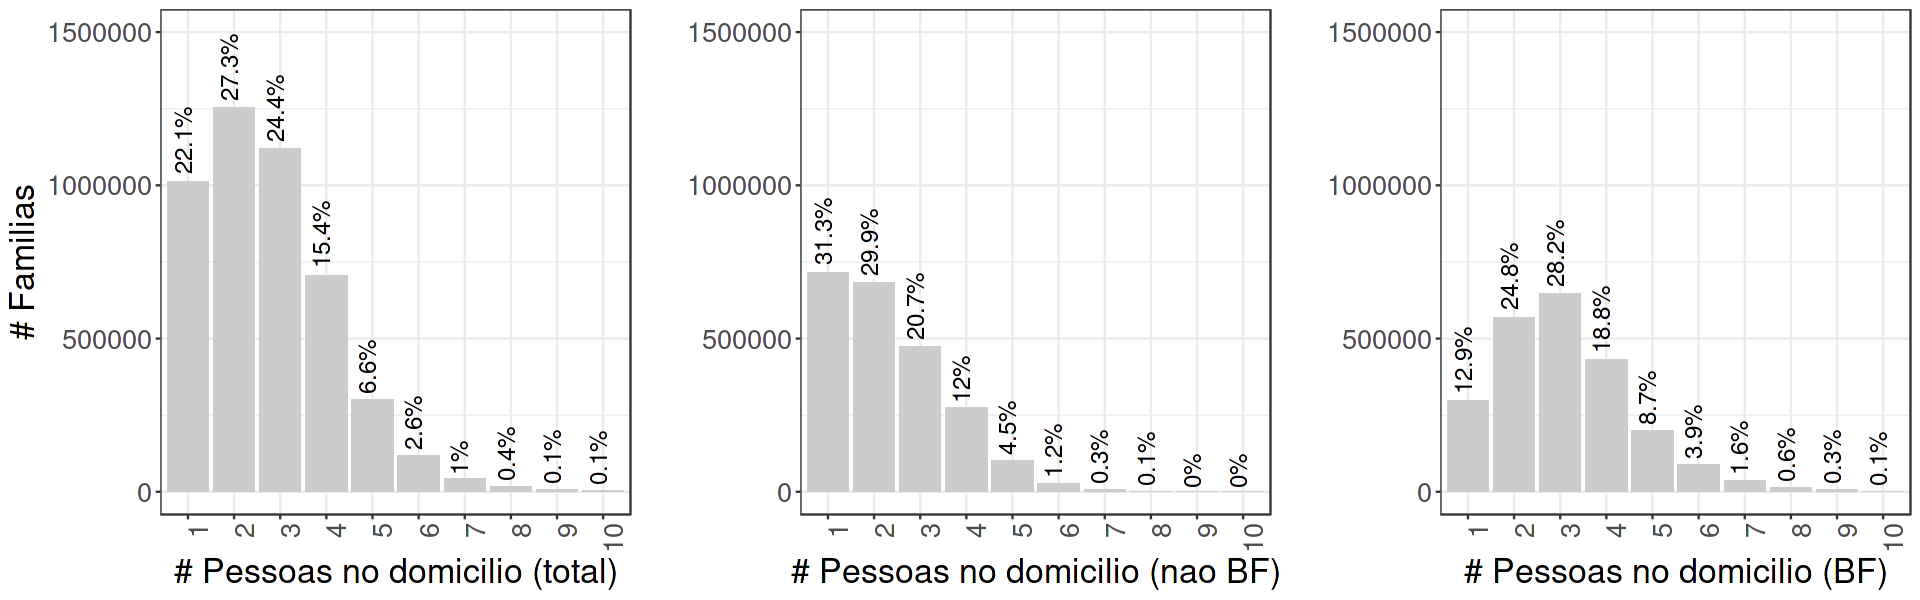

In [63]:
# Vertical bound of the plot
max_y <- 1500000
break_y <- 500000

# Plot of the number of family members (entire population)
plt_pessoas_all <- ggplot(df_pessoas_all, aes(x = factor(Var1), y = Freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme +
    ylab("# Familias") +
    xlab("# Pessoas no domicilio (total)") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    geom_text(aes(label = perc_pessoas_all), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

# Plot of the number of family members (non BF families)
plt_pessoas_bf0 <- ggplot(df_pessoas_bf0, aes(x = factor(Var1), y = Freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    theme_bw() + 
    mytheme +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ylab("") +
    xlab("# Pessoas no domicilio (nao BF)") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    geom_text(aes(label = perc_pessoas_bf0), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

# Plot of the number of family members (BF families)
plt_pessoas_bf1 <- ggplot(df_pessoas_bf1, aes(x = factor(Var1), y = Freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    theme_bw() + 
    mytheme +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ylab("") +
    xlab("# Pessoas no domicilio (BF)") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    geom_text(aes(label = perc_pessoas_bf1), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

# Display plots side-by-side
options(repr.plot.width = 16, repr.plot.height = 5)
grid.arrange(plt_pessoas_all, plt_pessoas_bf0, plt_pessoas_bf1, ncol = 3)

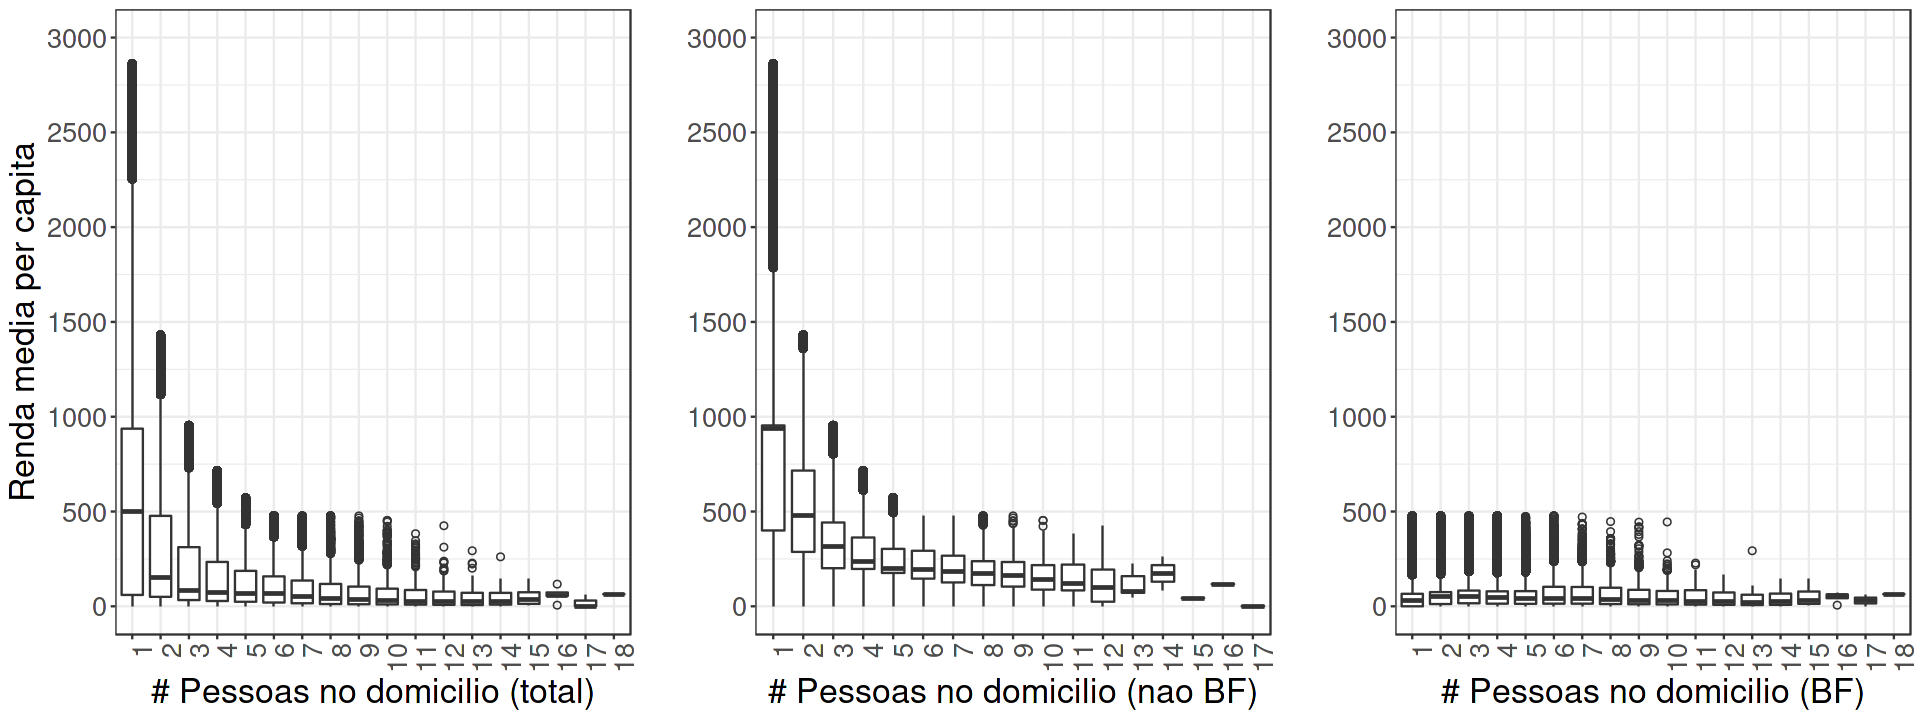

In [33]:
# Vertical bound of the plot
max_y_renda <- 3000
break_y <- 500

# Plot of average income distribution as a function of the family size (entire population)
plt_renda_pessoas_all <- ggplot(df, aes(x = factor(qtde_pessoas), y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme +
    ylab("Renda media per capita") +
    xlab("# Pessoas no domicilio (total)") +
    scale_y_continuous(limits = c(0, max_y_renda), breaks = seq(0, max_y_renda, break_y))

# Plot of average income distribution as a function of the family size (non BF families)
plt_renda_pessoas_bf0 <- ggplot(df[df$marc_pbf == 0,], aes(x = factor(qtde_pessoas), y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme +
    ylab("") +
    xlab("# Pessoas no domicilio (nao BF)") +
    scale_y_continuous(limits = c(0, max_y_renda), breaks = seq(0, max_y_renda, break_y))

# Plot of average income distribution as a function of the family size (BF families)
plt_renda_pessoas_bf1 <- ggplot(df[df$marc_pbf == 1,], aes(x = factor(qtde_pessoas), y = vlr_renda_media_fam)) +
    geom_boxplot(outlier.shape = 1) +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme +
    ylab("") +
    xlab("# Pessoas no domicilio (BF)") +
    scale_y_continuous(limits = c(0, max_y_renda), breaks = seq(0, max_y_renda, break_y))

# Display plots side-by-side
options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(plt_renda_pessoas_all, plt_renda_pessoas_bf0, plt_renda_pessoas_bf1, ncol = 3)

## Home conditions and the provision of basic services
In this section, we analyse home conditions and the provision of basic services, such as the supply of water 
and electricity, and the collection of gabage and sewage. We present some preliminary analysis, comparing BF beneficiary families with non-beneficiaries.

**Summary:**

If we consider the entire population, we observe the following:
* Most of the material used on the floor is ceramic, stone or cement (90%), while 5% is made of wood;
* Most of the houses are made by brick (alvenaria) on the walls. However, a significant number of houses are made of wood (~ 8%);
* Approximately 77% of the families are supplied by a water distribution network, and around 96% of the families have electricity in their homes;
* Around 83% of the families have some type of garbage collection (directly or indirectly);
* Most families are not reached by a sewage collection system. About 49% of the families are supplied with collection, 27% have a rudimentary cesspool, and 14% have a septic tank.
* Most families are supplied with a system of piped water, has at least one toillet, and are reached by some system of garbage collection.

When we compare families participating in the BF program with those not participating, we hightlight the following:
* Among families not registered in the program, 57% has sewage collection in their homes. In BF-registered families, this number is more dramatic: only 41% of the homes have access to a sewage collection system;
* 93% of the families not registered in BF are supplied by a system of piped water. This amount drops to 82% in BF-registered families;
* Around 10% of the families outside the program has no garbage collection, against 22% among those families listed in the program.

In [60]:
# Type of material on the floor
freq_material_piso <- data.frame(table(df$cod_material_piso_fam))

# Type of material on the wall
freq_material_parede <- data.frame(table(df$cod_material_domic_fam))

# Form of water supply
freq_abastecimento_agua <- data.frame(table(df$cod_abaste_agua_domic_fam))

# Form of garbage collection
freq_destino_lixo <- data.frame(table(df$cod_destino_lixo_domic_fam))

# Lighting type
freq_iluminacao <- data.frame(table(df$cod_iluminacao_domic_fam))

# Form of sanitary outflow
freq_escoa_sanitario <- data.frame(table(df$cod_escoa_sanitario_domic_fam))

freq_escoa_sanitario
sum(freq_escoa_sanitario$Freq)

Var1,Freq
<fct>,<int>
Fossa rudimentar,1243425
Fossa septica,648651
Outro,303673
Rede coletora,2256698
"Rio, lago ou mar",42884
Vala a ceu aberto,88046


[1] 4583377

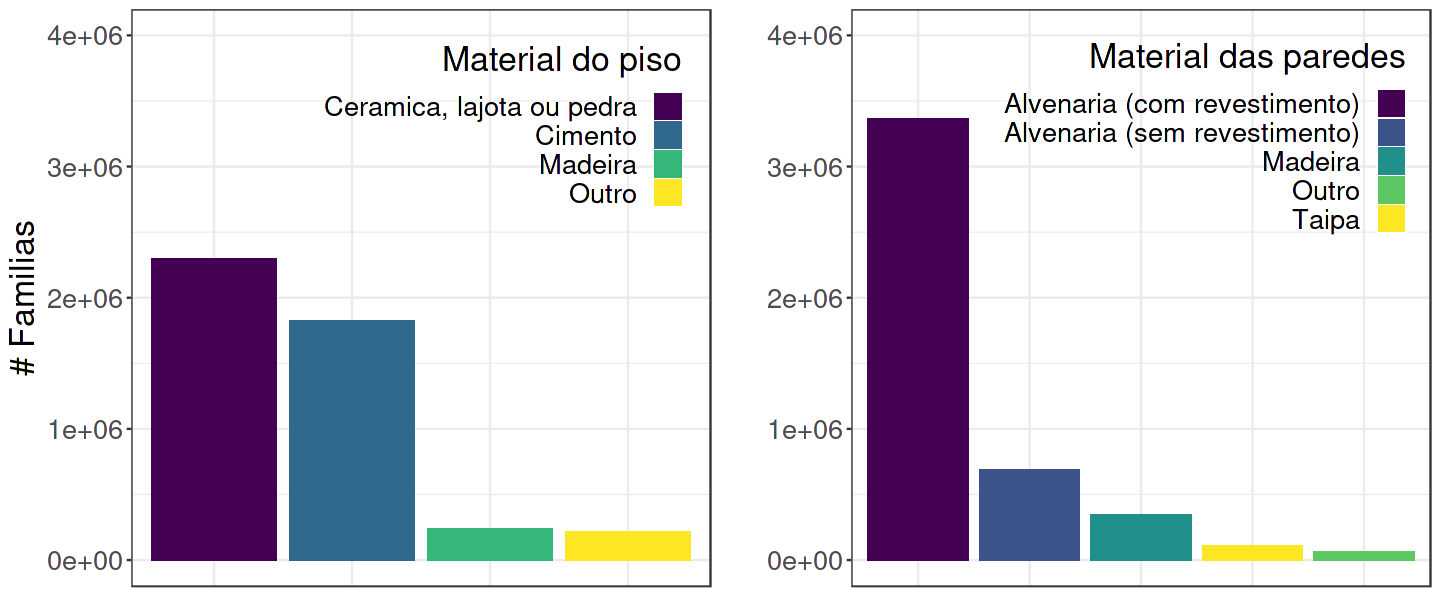

In [24]:
# Vertical bound of the plot
max_y_material <- 4000000
break_y <- 1000000

# Plot of the distribution of families according to the type of material on the floor
plt_material_piso <- ggplot(freq_material_piso, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.65, 0.8),
        legend.background = element_rect(fill = "transparent", size = 0.3, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("# Familias") +
    labs(fill = "Material do piso") +
    scale_y_continuous(limits = c(0, max_y_material), breaks = seq(0, max_y_material, break_y))

# Plot of the distribution of families according to the type of material on the wall
plt_material_parede <- ggplot(freq_material_parede, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.62, 0.78),
        legend.background = element_rect(fill = "transparent", size = 0.3, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("") +
    labs(fill = "Material das paredes") +
    scale_y_continuous(limits = c(0, max_y_material), breaks = seq(0, max_y_material, break_y))

# Display plots side-by-side
options(repr.plot.width = 12, repr.plot.height = 5)
grid.arrange(plt_material_piso, plt_material_parede, ncol = 2)

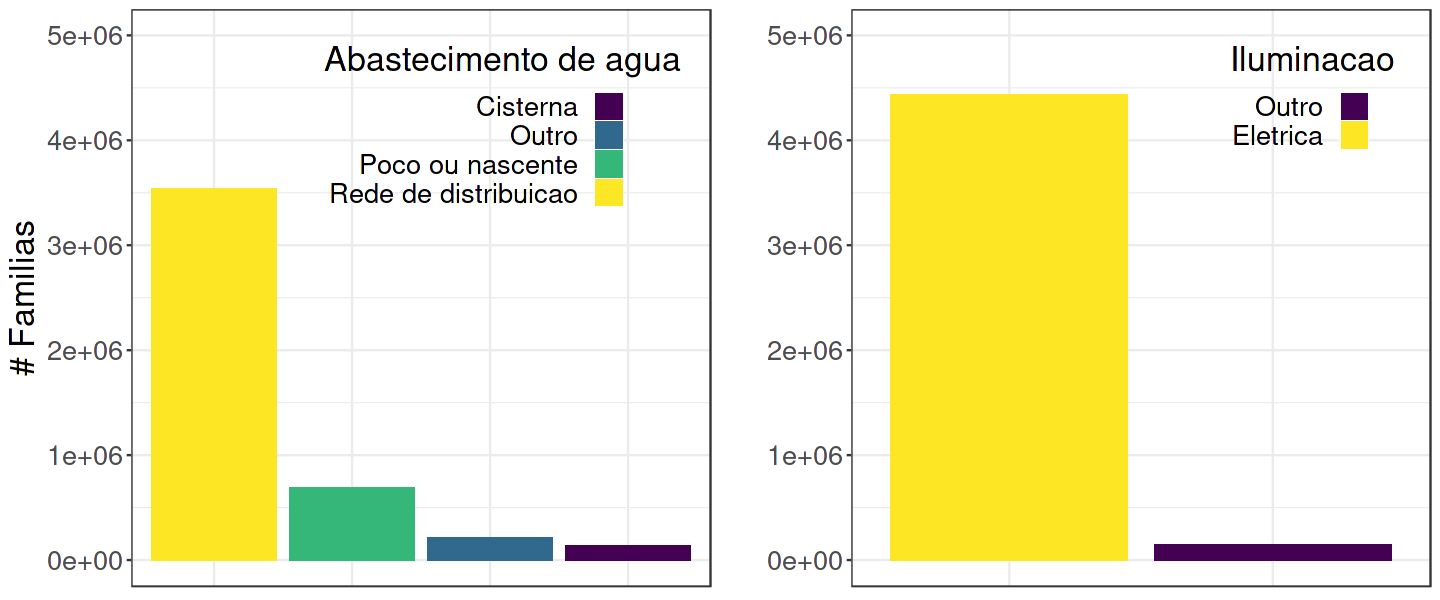

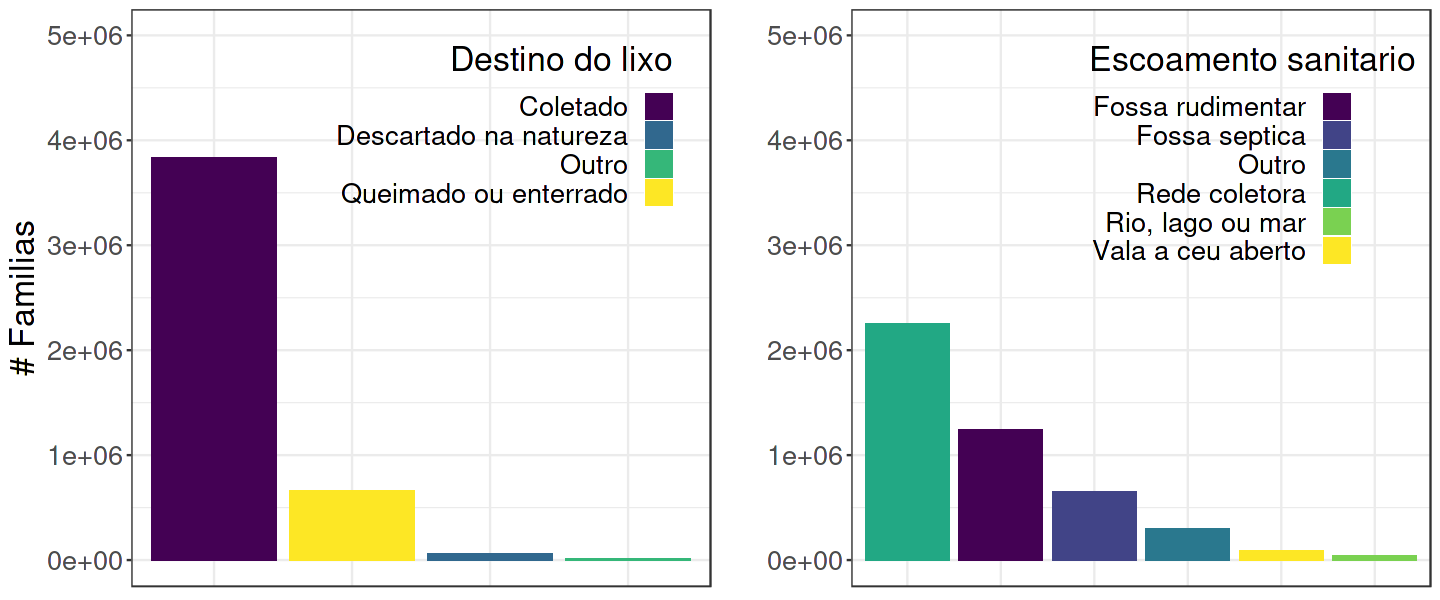

In [25]:
# Vertical bound of the plot
max_y <- 5000000
break_y <- 1000000

# Plot of the distribution of families according to the form of water supply
plt_abastecimento_agua <- ggplot(freq_abastecimento_agua, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.65, 0.8),
        legend.background = element_rect(fill = "transparent", size = 0.3, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("# Familias") +
    labs(fill = "Abastecimento de agua") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y))

# Plot of the distribution of families according to the form of garbage collection
plt_destino_lixo <- ggplot(freq_destino_lixo, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.65, 0.8),
        legend.background = element_rect(fill = "transparent", size = 0.2, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("# Familias") +
    labs(fill = "Destino do lixo") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y))

# Plot of the distribution of families according to eletricity supply (yes or no)
plt_iluminacao <- ggplot(freq_iluminacao, aes(
                    x = reorder(Var1, -Freq),
                    y = Freq,
                    fill = factor(Var1, levels = 0:1, labels = c('Outro', 'Eletrica')))) +
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.8, 0.85),
        legend.background = element_rect(fill = "transparent", size = 0.2, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("") +
    labs(fill = "Iluminacao") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y))

# Plot of the distribution of families according to the form of sanitary outflow
plt_escoa_sanitario <- ggplot(freq_escoa_sanitario, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) +
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.7, 0.75),
        legend.background = element_rect(fill = "transparent", size = 0.2, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("") +
    labs(fill = "Escoamento sanitario") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y))

# Display plots in a 2x2 grid
options(repr.plot.width = 12, repr.plot.height = 5)
grid.arrange(plt_abastecimento_agua, plt_iluminacao, ncol = 2)
grid.arrange(plt_destino_lixo, plt_escoa_sanitario, ncol = 2)

In [26]:
# Dataframe for water supply, discriminated by BF indicator
df_agua <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_agua_canalizada_fam)), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_agua_canalizada_fam)), bf = rep(1, 2))
)

# Dataframe for bathroom existence, discriminated by BF indicator
df_banheiro <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_banheiro_domic_fam)), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_banheiro_domic_fam)), bf = rep(1, 2))
)

# Dataframe for sewage collection, discriminated by BF indicator
df_rede_esg <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_escoa_sanitario_domic_fam == "Rede coletora")), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_escoa_sanitario_domic_fam == "Rede coletora")), bf = rep(1, 2))
)

# Dataframe for garbage collection, discriminated by BF indicator
df_lixo <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_destino_lixo_domic_fam == "Coletado")), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_destino_lixo_domic_fam == "Coletado")), bf = rep(1, 2))
)

# Redefine column names
colnames(df_agua) <- c("agua", "freq", "bf")
colnames(df_banheiro) <- c("banheiro", "freq", "bf")
colnames(df_rede_esg) <- c("coleta", "freq", "bf")
colnames(df_lixo) <- c("coleta", "freq", "bf")

# Water supply, in terms of percentage
percs_agua <- c(
    100*round(df_agua[df_agua$bf == 0, ]$freq/sum(df_agua[df_agua$bf == 0, ]$freq), 3),
    100*round(df_agua[df_agua$bf == 1, ]$freq/sum(df_agua[df_agua$bf == 1, ]$freq), 3)
)

# Bathroom existence, in terms of percentage
percs_banheiro <- c(
    100*round(df_banheiro[df_banheiro$bf == 0, ]$freq/sum(df_banheiro[df_banheiro$bf == 0, ]$freq), 3),
    100*round(df_banheiro[df_banheiro$bf == 1, ]$freq/sum(df_banheiro[df_banheiro$bf == 1, ]$freq), 3)
)

# Garbage collection, in terms of percentage
percs_lixo <- c(
    100*round(df_lixo[df_lixo$bf == 0, ]$freq/sum(df_lixo[df_lixo$bf == 0, ]$freq), 3),
    100*round(df_lixo[df_lixo$bf == 1, ]$freq/sum(df_lixo[df_lixo$bf == 1, ]$freq), 3)
)

# SewageScollection, in terms of percentage
percs_rede_esg <- c(
    100*round(df_rede_esg[df_rede_esg$bf == 0, ]$freq/sum(df_rede_esg[df_rede_esg$bf == 0, ]$freq), 3),
    100*round(df_rede_esg[df_rede_esg$bf == 1, ]$freq/sum(df_rede_esg[df_rede_esg$bf == 1, ]$freq), 3)
)

# Add '%' symbol
percs_agua <- paste(percs_agua, '%', sep = '')
percs_banheiro <- paste(percs_banheiro, '%', sep = '')
percs_lixo <- paste(percs_lixo, '%', sep = '')
percs_rede_esg <- paste(percs_rede_esg, '%', sep = '')

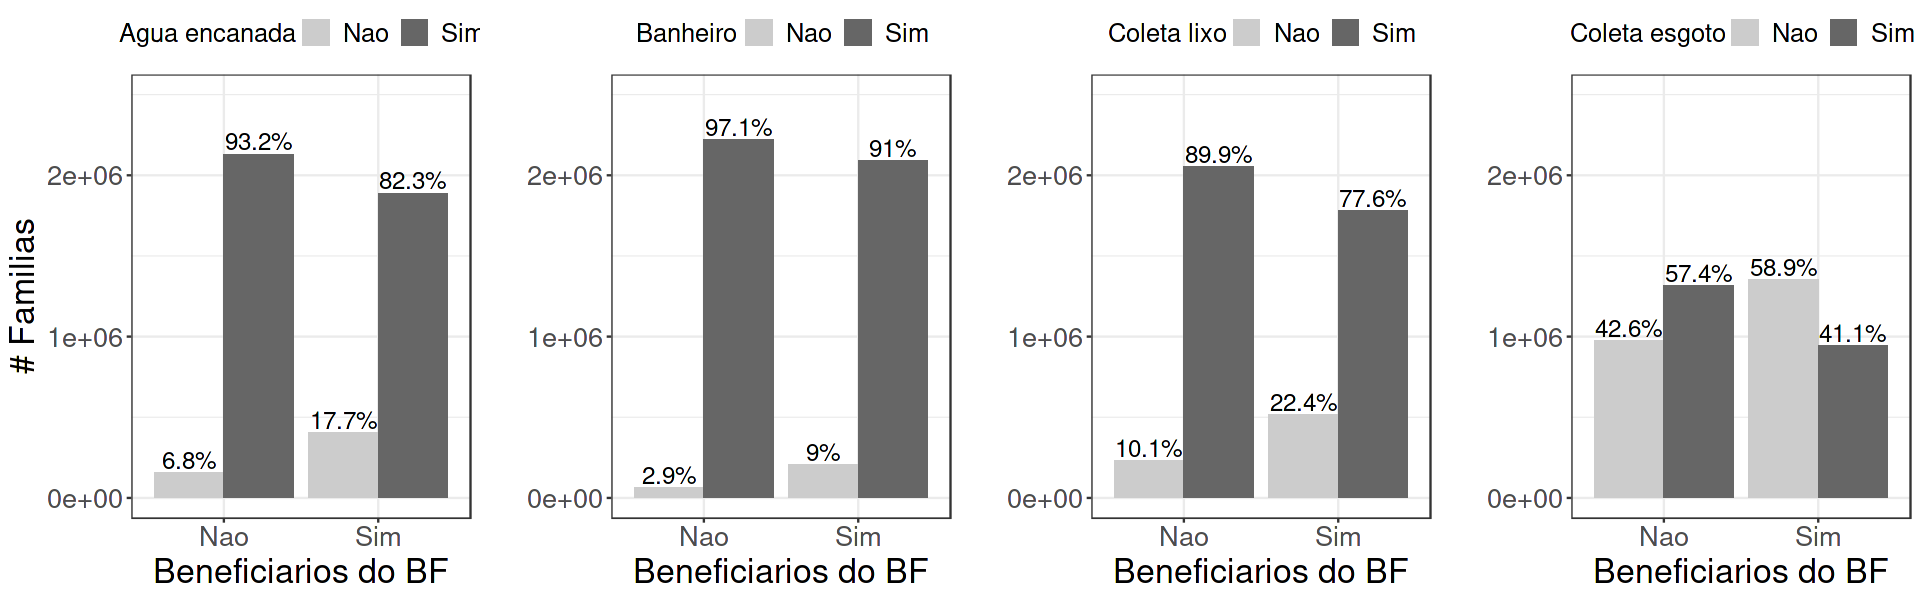

In [27]:
# Vertical bound
max_y <- 2500000
break_y <- 1000000

# Bars colors
colors <- c("grey80", "grey40")

# Plot: water supply
plt_agua <- ggplot(df_agua, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(agua, levels = 0:1, labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("# Familias") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_agua), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Agua encanada") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

# Plot: existence of bathroom
plt_banheiro <- ggplot(df_banheiro, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(banheiro, levels = 0:1, labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_banheiro), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Banheiro") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

# Plot: garbage collection
plt_lixo <- ggplot(df_lixo, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(coleta, levels = c(FALSE, TRUE), labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_lixo), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Coleta lixo") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

# Plot: sewage collection
plt_rede_esg <- ggplot(df_rede_esg, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(coleta, levels = c(FALSE, TRUE), labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, break_y)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_rede_esg), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Coleta esgoto") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

# Display plots side-by-side
options(repr.plot.width = 16, repr.plot.height = 5)
grid.arrange(plt_agua, plt_banheiro, plt_lixo, plt_rede_esg, ncol = 4)

## Variables correlation
In this section we analyse the correlation between the variables of the dataset. The goal of this section is to highlight the largest correlations among the columns, and prepare the data for the creation of new features and for a future prediction task. We first apply the on-hot encoding scheme in all categorical variables, generating binary variables. Next, we calculate the Pearson correlation between every variable, and highlight the 20 pairs of variables with the largest (and lowest) correlations.

**Summary:**
Apart from some relationships that are obvious (for example <code>qtd_comodos_domic_fam</code> and <code>qtd_comodos_dormitorio_fam</code> highly correlate), we highlight the following:

* There is a strong positive correlation between living in urban areas, collected garbage, piped water systems, and the existence of sidewalks;

* In addition, the presence of water wells correlates positively with burnt or buried garbage; and living in metropolitan areas correlates positively with houses whose walls are made of brick (alvenaria).

* Burnt or buried garbage negatively correlates with living in metropolitan areas and piped water systems;

* Average income per capita negatively correlates with being part of the BF program;

* Living in metropolitan areas negatively correlates with houses whose walls are made of wood.

In [28]:
# One-hot encoding
dummy <- dummyVars(" ~ .", data = df)

# Due to memory limitations, we randomly sample 1M rows (typically does not affect the correlations outcome)
set.seed(1645)
df_sampled <- df[sample(nrow(df), 1000000), ]
df_sampled <- data.frame(predict(dummy, newdata = df_sampled))

In [29]:
# Overview of the derived dataset
head(df_sampled)
nrow(df_sampled)
ncol(df_sampled)

,estrato,classf,vlr_renda_media_fam,cod_local_domic_fam,qtd_comodos_domic_fam,qtd_comodos_dormitorio_fam,cod_material_piso_famCeramica..lajota.ou.pedra,cod_material_piso_famCimento,cod_material_piso_famMadeira,cod_material_piso_famOutro,⋯,cod_escoa_sanitario_domic_famVala.a.ceu.aberto,cod_destino_lixo_domic_famColetado,cod_destino_lixo_domic_famDescartado.na.natureza,cod_destino_lixo_domic_famOutro,cod_destino_lixo_domic_famQueimado.ou.enterrado,cod_iluminacao_domic_fam,cod_calcamento_domic_fam,indigena_quilombola,marc_pbf,qtde_pessoas
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4226614,1,1,954,1,3,1,1,0,0,0,⋯,0,1,0,0,0,1,1,0,0,1
205618,0,0,233,1,5,1,0,1,0,0,⋯,0,1,0,0,0,1,0,0,0,3
2233686,1,0,468,1,3,1,0,1,0,0,⋯,0,1,0,0,0,1,1,0,0,4
4712690,1,1,27,1,3,1,1,0,0,0,⋯,0,1,0,0,0,1,1,0,1,3
2662482,1,0,220,1,4,1,1,0,0,0,⋯,0,1,0,0,0,1,1,0,0,1
328568,1,0,700,1,6,3,1,0,0,0,⋯,0,1,0,0,0,1,1,0,0,3


[1] 1000000

[1] 36

In [30]:
# Flatten the coorelation matrix, generating a table representation
flatCorMatrix <- function(cormat, pmat) {
    M <- ncol(cormat)
    u <- 1
    rows_idx <- rep(0, M*(M-1)/2)
    cols_idx <- rep(0, M*(M-1)/2)
    corr <- rep(0, M*(M-1)/2)
    pval <- rep(0, M*(M-1)/2)
    
    for (i in seq(1, M-1)) {
        for (j in seq(i+1, M)) {
            rows_idx[u] <- i
            cols_idx[u] <- j
            corr[u] <- cormat[i, j]
            pval[u] <- pmat[i, j]
            u <- u+1
        }
    }
    data.frame(
        row = rownames(cormat)[row(cormat)][rows_idx],
        column = rownames(cormat)[row(cormat)][cols_idx],
        cor = corr,
        p = pval
    )
}

In [31]:
# Filter the columns we want to drop from the correlation matrix
# cor_features <- cor(newdata[, !(names(newdata) %in% c("id_familia"))])
cor_features <- cor(df_sampled)

# Pearson correlatin matrix
cor_matrix <- rcorr(as.matrix(df_sampled))

# Get the correlations and p-values in a table format
df_cor <- flatCorMatrix(cor_matrix$r, cor_matrix$P)

# Display the 20 largest correlations
df_cor[order(-df_cor$cor),][1:10,]

# Display the 20 lowest correlations
df_cor[order(df_cor$cor),][1:10,]

,row,column,cor,p
,<fct>,<fct>,<dbl>,<dbl>
126,cod_local_domic_fam,cod_destino_lixo_domic_famColetado,0.6982623,0
135,qtd_comodos_domic_fam,qtd_comodos_dormitorio_fam,0.6841698,0
256,cod_material_piso_famMadeira,cod_material_domic_famMadeira,0.6690222,0
424,cod_agua_canalizada_fam,cod_abaste_agua_domic_famRede.de.distribuicao,0.5916312,0
502,cod_abaste_agua_domic_famRede.de.distribuicao,cod_destino_lixo_domic_famColetado,0.5432162,0
118,cod_local_domic_fam,cod_abaste_agua_domic_famRede.de.distribuicao,0.5341928,0
131,cod_local_domic_fam,cod_calcamento_domic_fam,0.5281000,0
599,cod_destino_lixo_domic_famColetado,cod_calcamento_domic_fam,0.5242016,0
432,cod_agua_canalizada_fam,cod_destino_lixo_domic_famColetado,0.4793385,0


,row,column,cor,p
,<fct>,<fct>,<dbl>,<dbl>
513,cod_banheiro_domic_fam,cod_escoa_sanitario_domic_famOutro,-0.9419647,0
597,cod_destino_lixo_domic_famColetado,cod_destino_lixo_domic_famQueimado.ou.enterrado,-0.9340349,0
196,cod_material_piso_famCeramica..lajota.ou.pedra,cod_material_piso_famCimento,-0.8174489,0
478,cod_abaste_agua_domic_famPoco.ou.nascente,cod_abaste_agua_domic_famRede.de.distribuicao,-0.7756237,0
306,cod_material_domic_famAlvenaria..com.revestimento.,cod_material_domic_famAlvenaria..sem.revestimento.,-0.6984986,0
129,cod_local_domic_fam,cod_destino_lixo_domic_famQueimado.ou.enterrado,-0.6885126,0
101,vlr_renda_media_fam,marc_pbf,-0.6452511,0
528,cod_escoa_sanitario_domic_famFossa.rudimentar,cod_escoa_sanitario_domic_famRede.coletora,-0.6007328,0
505,cod_abaste_agua_domic_famRede.de.distribuicao,cod_destino_lixo_domic_famQueimado.ou.enterrado,-0.5269414,0


## Concluding remarks